#  活动推荐算法
    
Event Recommendation Engine Challenge是Kaggle上的一个推荐任务竞赛，根据用户的历史参加活动记录、社交信息以及在 App上浏览和点击的活动，预测用户是否会对某个活动感兴趣。

根据协同过滤算法原理，采用3种算法预测用户对活动的感兴趣程度：    
1. 基于用户的协同过滤(用户本身，用户好友分析)；     
2. 基于活动的协同过滤(活动本身，用户活动关联分析)；     
3. 基于模型的协同过滤。   

# 1.  数据分析

In [1]:
import pandas as pd
import numpy as np
from numpy.random import random 

import scipy.sparse as ss
import scipy.io as sio
import scipy.spatial.distance as ssd

from collections import defaultdict
from sklearn.preprocessing import normalize
from utils import FeatureEng

import itertools
import pickle

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
#  统计训练集和测试集中的用户('user')和活动('event') 

uniqueUsers = set()
uniqueEvents = set() 

for filename in ['train.csv','test.csv']:
    f = open(filename)
    f.readline().strip().split(',')       
    for line in f:
        cols = line.strip().split(',')
        uniqueUsers.add(cols[0])         
        uniqueEvents.add(cols[1])         
    f.close()
        
n_uniqueUsers = len(uniqueUsers)
n_uniqueEvents = len(uniqueEvents)
print('训练集和测试集中用户总数：',n_uniqueUsers)
print('训练集和测试集中活动总数：',n_uniqueEvents)

userIndex = dict()
eventIndex = dict()

for i,u in enumerate(uniqueUsers):
    userIndex[u] = i
for i,e in enumerate(uniqueEvents):
    eventIndex[e] = i

pickle.dump(userIndex,open('userIndex.pkl','wb'))
pickle.dump(eventIndex,open('eventIndex.pkl','wb'))

训练集和测试集中用户总数： 3391
训练集和测试集中事件总数： 13418


统计训练集和测试集中的用户('user')和活动('event')，构建用户和活动索引字典：         
1) userIndex.pkl文件： 保存 {‘用户’：索引} 字典：{'3389282421': 0, '1066372954': 1, '2010045207': 2, . . .}       
2) eventIndex.pkl文件：保存 {‘活动’：索引} 字典：{'2223895704': 0, '3923328825': 1, '1184964740': 2, . . .}      

In [53]:
# 统计'用户-活动'关系 

eventsForUser = defaultdict(set)   
usersForEvent = defaultdict(set)

userEventScores = ss.dok_matrix((n_uniqueUsers, n_uniqueEvents)) 

ftrain = open('train.csv')
ftrain.readline() 
for line in ftrain:
    cols = line.strip().split(',')
    i = userIndex[cols[0]]          
    j = eventIndex[cols[1]]          
    
    eventsForUser[i].add(j)          
    usersForEvent[j].add(i)         
    
    score = int(cols[4])
    userEventScores[i,j] = score     
ftrain.close()

pickle.dump(eventsForUser,open('eventsForUser.pkl','wb')) 
pickle.dump(usersForEvent,open('usersForEvent.pkl','wb'))

sio.mmwrite('userEventScores',userEventScores)

统计'用户-活动'关系:      
1) eventsForUser.pkl文件：保存‘用户参加的活动’：{用户：{参加的活动}} -> {1437: {11779, 2022, 9447, 7081, 1501, 11806}, 2491: {9475, 12103, 9320, 8592, 4273, 10228, 10325}, . . .}         
2) usersForEvent.pkl文件：保存‘参加活动的用户’：{参加的活动：{用户}} -> {9447: {1433, 1437}, 1501: {1321, 868, 1437, 846}, . . .}     
3) userEventScores.mtx文件：保存‘用户对活动的兴趣’：{(用户,活动) 兴趣} ->        
(1437, 2022)	1.0        
(2491, 10325)	1.0        
(2491, 8592)	1.0         
. . .    
userEventScores.getrow(i).todense()可获得索引号为i的用户对所有活动的兴趣，比如对于2491号用户：[[0. 0. 0. ... 0. 0. 0.]]     

In [62]:
# 统计关联用户和关联活动 

uniqueUserPairs = set() 
uniqueEventPairs = set() 

for event in uniqueEvents:
    i = eventIndex[event]         
    users = usersForEvent[i]      
    if len(users)>2:
        uniqueUserPairs.update(itertools.combinations(users,2))  

for user in uniqueUsers:            
    u = userIndex[user]           
    events = eventsForUser[u]     
    if len(events)>2:
        uniqueEventPairs.update(itertools.combinations(events,2))  
        
pickle.dump(uniqueUserPairs,open('uniqueUserPairs.pkl','wb'))
pickle.dump(uniqueEventPairs,open('uniqueEventPairs.pkl','wb'))

统计关联用户和关联活动:       
1) uniqueUserPairs.pkl文件：参加某一活动的所有用户，形成的两两用户对，即关联用户：{(234, 3007), (2912, 1979), (2197, 533), (681, 1396), (1417, 3028), (3306, 3335), (2167, 3339), (849, 1982), . . .}       
2) uniuqeEventPairs.pkl文件：某个用户参加的所有活动，形成的两两活动对，即关联活动：{(4001, 12866), (2261, 2169), (10614, 4855), (10036, 3480), (612, 2088), (2758, 5259), (161, 5787), (6304, 12369), . . .}     

In [6]:
# 读取文件‘users.csv’,用于对输入特征进行特征编码

users = pd.read_csv('users.csv')
users.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [21]:
# 对在训练集和测试集中出现的user_id对应的输入特征进行特征编码

userIndex = pickle.load(open('userIndex.pkl','rb'))
n_users = len(userIndex)

FE = FeatureEng.FeatureEng()                    
n_cols = users.shape[1]-1 
userMatrix = ss.dok_matrix((n_users, n_cols))   

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'CountryId', 'TimezoneInt'] 
for u in range(len(users)): 
    userId = str(users.loc[u,'user_id'])                                 
    if userId in userIndex.keys():                                      
        i = userIndex[userId]                                            
        userMatrix[i,0] = FE.getLocaleId(users.loc[u,'locale'])          
        userMatrix[i,1] = FE.getBirthYearInt(users.loc[u,'birthyear'])
        userMatrix[i,2] = FE.getGenderId(users.loc[u,'gender'])
        userMatrix[i,3] = FE.getJoinedYearMonth(users.loc[u,'joinedAt'])
        userMatrix[i,4] = FE.getCountryId(users.loc[u,'location'])     
        userMatrix[i,5] = FE.getTimezoneInt(users.loc[u,'timezone'])
        
userMatrix = normalize(userMatrix, norm="l2", axis=0, copy=False)
sio.mmwrite('userMatrix', userMatrix)

In [23]:
# 计算关联用户的相似度 

userSimMatrix = ss.dok_matrix((n_users,n_users))
for i in range(n_users):             
    userSimMatrix[i,i] = 1.0            

uniqueUserPairs = pickle.load(open('uniqueUserPairs.pkl','rb'))   
for u1,u2 in uniqueUserPairs: 
    i = u1 
    j = u2 
    if (i,j) not in userSimMatrix.keys():
        usim = ssd.correlation(userMatrix.getrow(i).todense(),userMatrix.getrow(j).todense())  
        userSimMatrix[i,j] = usim 
        userSimMatrix[j,i] = usim 
sio.mmwrite('userSimMatrix',userSimMatrix)


用户属性的特征编码和关联用户的相似度:           
1) userMatrix.mtx文件保存用户的特征编码：    
   (861, 0)	0.021628856085564065     
   (1356, 0)	0.011957416372506963    
    . . .    
   (1785, 5)	-0.01303142053748795    
   (2847, 5)	0.020850272859980718    
    . . .       
userMatrix.getrow(i).todense()可以读取索引号为i的用户的特征，比如第861号用户的特征为：[[ 0.02162886  0.01728704  0.01196254  0.01770409  0.         -0.01303142]] 

2) userSimMatrix文件保存关联用户的相似度：(关联用户在文件uniqueUserPairs.pkl中)            
  (828, 1821)	1.3388248003500465       
  (147, 466)	0.7114964412756368    
  (466, 147)	0.7114964412756368     
   . . . 

In [20]:
# 对在训练集和测试集中出现的event_id对应的输入特征进行特征编码

userIndex = pickle.load(open('eventIndex.pkl','rb'))
n_events = len(eventIndex)

FE = FeatureEng.FeatureEng()
eventPropMatrix = ss.dok_matrix((n_events, 7))    
eventContMatrix = ss.dok_matrix((n_events, 101))  

import linecache                                        
fevent = linecache.getlines("events.csv") 
for line in fevent: 
    cols = line.strip().split(",")
    eventId = str(cols[0])
    if eventId in eventIndex.keys():                                    
        i = eventIndex[eventId]                                         
        eventPropMatrix[i,0] = FE.getJoinedYearMonth(cols[2])              
        eventPropMatrix[i,1] = FE.getFeatureHash(cols[3].encode('utf-8'))  
        eventPropMatrix[i,2] = FE.getFeatureHash(cols[4].encode('utf-8'))  
        eventPropMatrix[i,3] = FE.getFeatureHash(cols[5].encode('utf-8')) 
        eventPropMatrix[i,4] = FE.getFeatureHash(cols[6].encode('utf-8'))  
        eventPropMatrix[i,5] = FE.getFloatValue(cols[7])                   
        eventPropMatrix[i,6] = FE.getFloatValue(cols[8])                   
        for j in range(9, 110):                                          
            eventContMatrix[i,j-9] = cols[j]
linecache.clearcache()

eventPropMatrxi = normalize(eventPropMatrix,norm='l2',axis=0,copy=False)
sio.mmwrite('eventPropMatrix',eventPropMatrix)

eventContMatrix = normalize(eventContMatrix,norm='l2',axis=0,copy=False)
sio.mmwrite('eventContMatrix', eventContMatrix)

In [21]:
# 计算关联活动的相似度

eventPropSim = ss.dok_matrix((n_events, n_events))   
eventContSim = ss.dok_matrix((n_events, n_events))  

uniqueEventPairs = pickle.load(open('uniqueEventPairs.pkl', 'rb')) 

for e1, e2 in uniqueEventPairs:
    i = e1
    j = e2  
    if (i,j) not in eventPropSim.keys():       
        epsim = ssd.correlation(eventPropMatrix.getrow(i).todense(),eventPropMatrix.getrow(j).todense()) 
        eventPropSim[i,j] = epsim
        eventPropSim[j,i] = epsim
    if (i,j) not in eventContSim.keys():     
        ecsim = ssd.cosine(eventContMatrix.getrow(i).todense(),eventContMatrix.getrow(j).todense())
        eventContSim[i,j] = epsim
        eventContSim[j,i] = epsim

sio.mmwrite('eventPropSim', eventPropSim)
sio.mmwrite('eventContSim', eventContSim)

C:\Users\l\Anaconda3\lib\site-packages\scipy\spatial\distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


活动的特征编码和关联活动的相似度:  
1) eventPropMatrix.mtx文件保存非词频的特征编码:  
  (9020, 0)	34.0   
  (9020, 1)	-1.0   
  (9020, 2)	-1.0   
   . . .     
2) eventContMatrix.mtx文件保存词频的特征编码：  
  (9020, 0)	0.03457021969314784    
  (5079, 0)	0.03457021969314784     
  (11304, 0)	0.01728510984657392  
  . . .    
3) eventPropSim.mtx文件保存关联活动非词频特征的相似度：(关联用户在文件uniqueEventPairs.pkl中)     
4) eventContSim.mtx文件保存关联活动词频特征的相似度     

In [34]:
# 统计‘用户-好友’对活动的兴趣

numFriends = np.zeros((n_users))                           
userFriends = ss.dok_matrix((n_users, n_users))

import linecache                                         
fri = linecache.getlines("user_friends.csv") 
for line in fri:                                     
    cols = line.strip().split(",")
    user = str(cols[0])                                 
    if user in userIndex.keys():                        
        friends = cols[1].split(" ")                  
        i = userIndex[user]                            
        numFriends[i] = len(friends)                  
        for friend in friends:                       
            str_friend = str(friend)
            if str_friend in userIndex.keys():        
                j = userIndex[str_friend]             
                newuser_score = userEventScores.getrow(j).todense()          
                score = newuser_score .sum() / np.shape(newuser_score)[1]    
                userFriends[i,j] += score                                    
                userFriends[j,i] += score  
linecache.clearcache()
 
sumNumFriends = numFriends.sum(axis=0)
numFriends = numFriends / sumNumFriends
sio.mmwrite('numFriends', np.matrix(numFriends))

userFriends = normalize(userFriends, norm="l2", axis=0, copy=False)
sio.mmwrite('userFriends', userFriends)

统计‘用户-好友’对活动的兴趣：     
1) numFriends.mtx文件保存用户的朋友总数     
2) userFriends.mtx文件保存用户的好友对活动的兴趣：       
  (3028, 19)	1.0    
  (3272, 221)	1.0      
   . . .     
  (2044, 237)	0.4472135954999579    
  (1550, 237)	0.8944271909999159     
    . . .    

In [40]:
# 统计某个活动，参加和不参加的人数，计算活动热度

eventIndex = pickle.load(open("eventIndex.pkl", 'rb'))
n_events = len(eventIndex)
eventPopularity = ss.dok_matrix((n_events,1))

import linecache  
event_file = linecache.getlines('event_attendees.csv') 
for line in event_file:  
    cols = line.strip().split(',')
    eventId = str(cols[0])
    if eventId in eventIndex.keys():
        i = eventIndex[eventId]                                                    
        eventPopularity[i,0] = len(cols[1].split(' ')) - len(cols[4].split(' '))   

eventPopularity = normalize(eventPopularity,norm='l1',axis=0,copy=False)
sio.mmwrite('eventPopularity',eventPopularity)

计算活动热度:  
1) eventPopularity.mtx文件保存活动活跃度：
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 ...
 [ 0.        ]
 [-0.00145762]
 [ 0.        ]]

 --------------------------------------------------------
小结1：   
分析数据集中的用户('user')和活动('event')属性，主要分析结果保存为文件，具体包括：        
1) userIndex和eventIndex： 分别是{‘用户’：索引} 和 {‘活动’：索引} 字典，部分具体数据为：{'2223895704': 0, '3923328825': 1, '1184964740': 2, . . .}

2) eventsForUser和usersForEvent：分别是‘用户参加的活动’-> {用户：{参加的活动}}和‘参加活动的用户’-> {参加的活动：{用户}}，部分具体数据为： {1437: {11779, 2022, 9447, 7081, 1501, 11806}, 2491: {9475, 12103, 9320, 8592, 4273, 10228, 10325}, . . .}

3) userEventScores：是‘用户对活动的兴趣’-> {(用户,活动) 兴趣} ，部分具体数据为：  
(1437, 2022) 1.0
(2491, 10325) 1.0
(2491, 8592) 1.0
. . .
userEventScores.getrow(i).todense()可获得索引号为i的用户对所有活动的兴趣。

4) uniqueUserPairs和uniuqeEventPairs：分别是关联用户和关联活动，关联用户是参加某一活动的所有用户，形成的两两用户对，关联活动是某个用户参加的所有活动，形成的两两活动对，部分具体数值为：{(234, 3007), (2912, 1979), (2197, 533), (681, 1396),  . . .}   

5) userMatrix是用户属性的特征编码，userMatrix.getrow(i).todense()可以读取索引号为i的用户的特征。userSimMatrix是关联用户的相似度。

6) eventPropMatrix是活动的非词频特征编码，eventContMatrix是活动的词频特征编码。eventPropSim是关联活动的非词频特征的相似度，eventContSim是关联活动词频特征的相似度。

7) ‘用户-好友’对活动的兴趣：numFriends是用户的朋友总数；userFriends是用户的好友对活动的兴趣，部分具体数据为：  
(3028, 19) 1.0
(3272, 221) 1.0
. . .
(2044, 237) 0.4472135954999579
(1550, 237) 0.8944271909999159
. . . 

8) eventPopularity是活动活跃度： [[ 0. ] [ 0. ] [ 0. ] ... [ 0. ] [-0.00145762] [ 0. ]]


-------------------------------------------------------------
# 2.  数据读取   
直接读取前面分析保存好的数据，读取的数据用于后面的协同过滤。

In [2]:
# 读取上面数据分析保存的文件，对数据做初始化

# 用户和活动索引
userIndex = pickle.load(open('userIndex.pkl','rb'))
eventIndex = pickle.load(open('eventIndex.pkl','rb'))
n_users = len(userIndex)
n_items = len(eventIndex)

# 用户参加的活动和参加活动的用户
itemsForUser = pickle.load(open('eventsForUser.pkl','rb'))
usersForItem = pickle.load(open('usersForEvent.pkl','rb'))

# 用户-活动关系矩阵 
userEventScores = sio.mmread('userEventScores').todense()

# 用户属性的特征编码和根据用户属性计算出的用户之间的相似度
userMatrix = sio.mmread('userMatrix').todense()
userSimMatrix = sio.mmread('userSimMatrix').todense()

# 活动属性的特征编码和根据活动属性计算出的活动之间的相似度
eventPropMatrix = sio.mmread('eventPropMatrix').todense()
eventContMatrix = sio.mmread('eventContMatrix').todense()
eventPropSim = sio.mmread('eventPropSim').todense() 
eventContSim = sio.mmread('eventContSim').todense() 

# 每个用户的朋友的数目和每个朋友参加活动的分数对该用户的影响
numFriends = sio.mmread('numFriends')
userFriends = sio.mmread('userFriends').todense()

# 活动本身的热度
eventPopularity = sio.mmread('eventPopularity').todense()


In [3]:
# 读取训练集中的数据，并转化为列表格式，用来比较预测分值与实际分值的误差平方和

dtrain = pd.read_csv('train.csv')
data = dtrain[['user','event','interested']].values
n,m = data.shape 
print(n,m)

15398 3


---------------------------------------------
# 3.  实现基于用户的协同过滤（用户本身，用户好友分析）
基于用户的协同过滤，用两种方法计算两个用户user_1和user_2之间的相似度，分别是：  
1) 根据两个用户对活动打分的相似度；    
2) 由用户本身的特征属性计算相似度。       
再由已知用户对活动的评分(userEventScores‘用户对活动的兴趣’)计算用户对活动的推荐评分(兴趣)。 

In [7]:
# 1) 根据两个用户对活动打分的相似度，预测用户对活动的兴趣

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)        
diff_userScores = userEventScores - mean_userScores       
diff_userScores = np.array(diff_userScores)

userInterestSim = ss.dok_matrix((n_users,n_users))       
for i in range(n_users):             
    userInterestSim[i,i] = 1.0                           
    
uniqueUserPairs = pickle.load(open('uniqueUserPairs.pkl','rb'))
for u1,u2 in uniqueUserPairs:                           
    i = u1 
    j = u2 
    if (i,j) not in userInterestSim.keys():                      
        sim = sum(diff_userScores[i]*diff_userScores[j])\
        /np.sqrt(np.sum(np.power(diff_userScores[i],2)))/np.sqrt(np.sum(np.power(diff_userScores[j],2)))
        userInterestSim[i,j] = sim                        
        userInterestSim[j,i] = sim 
sio.mmwrite('userInterestSim',userInterestSim)


In [8]:
# 由用户相似度计算用户对活动的推荐评分 

user_similarity = sio.mmread('userInterestSim').todense()
user_similarity = np.mat(user_similarity)
user_similarity_sum =  np.sum(np.abs(user_similarity),axis=1)

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)
diff_userScores = userEventScores - mean_userScores 

userCFReco = mean_userScores + user_similarity * diff_userScores / user_similarity_sum
sio.mmwrite('userCFReco',userCFReco)


In [10]:
# 采用RMSE(mean_squared_error，总的误差平方和)作为评测标准，用来比较预测分值与实际分值，数值越小算法越好

user_Reco = sio.mmread('userCFReco') 
user_Reco = np.mat(user_Reco)

rmse_sum = 0.0    
for i in range(n):
    u_id = userIndex[str(data[i,0])]                             
    e_id = eventIndex[str(data[i,1])]                             
    rat = int(data[i,2])                                          
    eui = rat - user_Reco[u_id,e_id]                              
    rmse_sum += eui**2                                           
print('训练集分值总的误差平方和 (rmse of train data is) : ',np.sqrt(rmse_sum/n))  

训练集分值总的误差平方和 (rmse of train data is) :  0.5179708945175653


In [11]:
# 2) 根据用户本身的特征属性计算相似度，再计算活动的推荐度

userProSim = ss.dok_matrix((n_users,n_users))                    
for i in range(n_users):             
    userProSim[i,i] = 1.0                                       
    
uniqueUserPairs = pickle.load(open('uniqueUserPairs.pkl','rb'))
for u1,u2 in uniqueUserPairs:                                  
    i = u1 
    j = u2 
    if (i,j) not in userProSim.keys():                 
        sim = ssd.correlation(userMatrix[i,:],userMatrix[j,:])    
        userProSim[i,j] = sim                                                     
        userProSim[j,i] = sim 
sio.mmwrite('userProSim',userProSim)


In [12]:
# 由用户相似度计算用户对活动的推荐评分 

userPro_similarity = sio.mmread('userProSim').todense()
userPro_similarity = np.mat(userPro_similarity)
userPro_similarity_sum = np.sum(np.abs(userPro_similarity),axis=1)

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)
diff_userScores = userEventScores - mean_userScores 

userReco = mean_userScores + userPro_similarity * diff_userScores / userPro_similarity_sum
sio.mmwrite('userReco',userReco)

In [13]:
# 采用RMSE(mean_squared_error，总的误差平方和)作为评测标准，用来比较预测分值与实际分值，数值越小算法越好

user_Reco = sio.mmread('userReco') 
user_Reco = np.mat(user_Reco)

rmse_sum = 0.0    
for i in range(n):
    u_id = userIndex[str(data[i,0])]                             
    e_id = eventIndex[str(data[i,1])]                           
    rat = int(data[i,2])                                         
    eui = rat - user_Reco[u_id,e_id]                             
    rmse_sum += eui**2                                            
print('训练集分值总的误差平方和 (rmse of train data is) : ',np.sqrt(rmse_sum/n))  

训练集分值总的误差平方和 (rmse of train data is) :  0.51793963498875


小结3：  
基于用户的协同过滤，用两种方法计算两个用户user_1和user_2之间的相似度，再预测用户对活动的评分，采用RMSE(总的误差平方和)作为评测标准，比较了训练集的预测分值与实际分值的误差平方和：     
1) 根据两个用户对所有活动的打分，用Pearson相关系数(公式的第三种形式)计算两个用户的相似度，再由用户相似度计算用户对活动的推荐评分(userCFReco.mtx文件)，得到在训练集上预测分值与实际分值的误差平方和为：0.51797。   
2) 根据用户本身的特征属性，用Pearson相关系数(公式的第一种形式)计算两个用户的相似度，再由用户相似度计算用户对活动的推荐评分(userReco.mtx文件)，得到在训练集上预测分值与实际分值的误差平方和为：0.51794。          
由两种方法计算相似度得到的预测分值与实际分值的误差平方和相同。  


-------------------------------------------
# 4.  实现基于活动的协同过滤（活动本身，用户活动关联分析）
基于活动的协同过滤，用两种方法计算两个活动event_1和event_2之间的相似度，分别是：  
1) 根据两个活动打分的相似度；    
2) 由活动本身的特征属性计算相似度。       
再由已知用户对活动的评分(userEventScores‘用户对活动的兴趣’)计算用户对活动的推荐评分(兴趣)。 

In [26]:
# 1) 根据用户对两个活动打分的相似度，计算活动的推荐度

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)
diff_userScores = userEventScores - mean_userScores 
diff_userScores = np.array(diff_userScores)

eventInterestSim = ss.dok_matrix((n_items,n_items))
for i in range(n_items):             
    eventInterestSim[i,i] = 1.0                                         
    
uniqueEventPairs = pickle.load(open('uniuqeEventPairs.pkl','rb'))
for e1,e2 in uniqueEventPairs:                                        
    i = e1 
    j = e2 
    if (i,j) not in eventInterestSim.keys():                                
        sim = sum(diff_userScores[:,i]*diff_userScores[:,j])\
        /np.sqrt(np.sum(np.power(diff_userScores[:,i],2)))/np.sqrt(np.sum(np.power(diff_userScores[:,j],2)))
        eventInterestSim[i,j] = sim                        
        eventInterestSim[j,i] = sim 
sio.mmwrite('eventInterestSim',eventInterestSim) 
   

In [27]:
# 由活动相似度计算用户对活动的推荐评分 

event_similarity = sio.mmread('eventInterestSim').todense() 
event_similarity = np.mat(event_similarity)
event_similarity_sum = np.sum(np.abs(event_similarity),axis=0)

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)
diff_userScores = userEventScores - mean_userScores 

eventCFReco = mean_userScores + diff_userScores * event_similarity / event_similarity_sum
sio.mmwrite('eventCFReco',eventCFReco)

In [14]:
# 采用RMSE(mean_squared_error，总的误差平方和)作为评测标准，用来比较预测分值与实际分值，数值越小算法越好

event_Reco = sio.mmread('eventCFReco') 
event_Reco = np.mat(event_Reco)

rmse_sum = 0.0    
for i in range(n):
    u_id = userIndex[str(data[i,0])]                             
    e_id = eventIndex[str(data[i,1])]                              
    rat = int(data[i,2])                                           
    eui = rat - event_Reco[u_id,e_id]                              
    rmse_sum += eui**2                                             
print('训练集上预测分值与实际分值的误差平方和 (rmse of train data is) : ',np.sqrt(rmse_sum/n))  

训练集上预测分值与实际分值的误差平方和 (rmse of train data is) :  0.5181074097428295


In [22]:
# 2) 根据活动本身的特征属性计算相似度，再计算活动的推荐度

# 忽略错误信息
import warnings
warnings.filterwarnings('ignore')

eventPropMatrix = np.mat(eventPropMatrix)           
mean_eventProp = np.mean(eventPropMatrix,axis=1)
diff_eventProp = eventPropMatrix - mean_eventProp
diff_eventProp = np.array(diff_eventProp)

eventContMatrix = np.mat(eventContMatrix)            
mean_eventCont = np.mean(eventContMatrix,axis=1)
diff_eventCont = eventContMatrix - mean_eventCont
diff_eventCont = np.array(diff_eventCont)

eventPropSim = ss.dok_matrix((n_items, n_items))     
eventContSim = ss.dok_matrix((n_items, n_items))    

for i in range(n_items):             
    eventPropSim[i,i] = 1.0                        
    eventContSim[i,i] = 1.0   

uniqueEventPairs = pickle.load(open('uniqueEventPairs.pkl', 'rb'))         
for e1, e2 in uniqueEventPairs:
    i = e1
    j = e2  
    
    if (i,j) not in eventPropSim.keys():        
        epsim = sum(diff_eventProp[i]*diff_eventProp[j])\
        /np.sqrt(np.sum(np.power(diff_eventProp[i],2)))/np.sqrt(np.sum(np.power(diff_eventProp[j],2)))# 采用Person相关系数作为相似度
        eventPropSim[i,j] = epsim
        eventPropSim[j,i] = epsim
        
    if (i,j) not in eventContSim.keys():      
        ecsim = sum(diff_eventCont[i]*diff_eventCont[j])\
        /np.sqrt(np.sum(np.power(diff_eventCont[i],2)))/np.sqrt(np.sum(np.power(diff_eventCont[j],2)))# 采用Person相关系数作为相似度
        eventContSim[i,j] = ecsim
        eventContSim[j,i] = ecsim

sio.mmwrite('eventPropSimilarity', eventPropSim)
sio.mmwrite('eventContSimilarity', eventContSim)

In [16]:
# 由活动的非词频相似度计算用户对活动的推荐评分 

eventProp_sim = sio.mmread('eventPropSimilarity').todense()
eventProp_similarity = np.nan_to_num(eventProp_sim,0)
eventProp_similarity = np.mat(eventProp_similarity)
eventProp_similarity_sum = np.sum(np.abs(eventProp_similarity),axis=0)

userEventScores = np.mat(userEventScores)
mean_userScores = np.mean(userEventScores,axis=1)
diff_userScores = userEventScores - mean_userScores 

eventPropReco = mean_userScores + diff_userScores * eventProp_similarity / eventProp_similarity_sum
sio.mmwrite('eventPropReco',eventPropReco)
 

In [17]:
# 由活动的词频相似度计算用户对活动的推荐评分 

eventCont_sim = sio.mmread('eventContSimilarity').todense() 
eventCont_similarity = np.nan_to_num(eventCont_sim,0)
eventCont_similarity = np.mat(eventCont_similarity)
eventCont_similarity_sum = np.sum(np.abs(eventCont_similarity),axis=0)

eventContReco = mean_userScores + diff_userScores * eventCont_similarity / eventCont_similarity_sum
sio.mmwrite('eventContReco',eventContReco)


In [18]:
# 采用RMSE(mean_squared_error，总的误差平方和)作为评测标准，用来比较预测分值与实际分值，数值越小算法越好

eventProp_Reco = sio.mmread('eventPropReco') 
eventProp_Reco = np.mat(eventProp_Reco)

eventCont_Reco = sio.mmread('eventContReco')
eventCont_Reco = np.mat(eventCont_Reco)

rmse_sum_Prop = 0.0  
rmse_sum_Cont = 0.0
for i in range(n):
    u_id = userIndex[str(data[i,0])]                              
    e_id = eventIndex[str(data[i,1])]                              
    rat = int(data[i,2])                                           
    eui_Prop = rat - eventProp_Reco[u_id,e_id]                    
    eui_Cont = rat - eventCont_Reco[u_id,e_id]
    rmse_sum_Prop += eui_Prop**2                                 
    rmse_sum_Cont += eui_Cont**2

print('用非词频特征得到的预测分值与实际分值的误差平方和 (rmse of train data is) : ',np.sqrt(rmse_sum_Prop/n)) 
print('用词频特征得到的预测分值与实际分值的误差平方和 (rmse of train data is) : ',np.sqrt(rmse_sum_Cont/n))

用非词频特征得到的预测分值与实际分值的误差平方和 (rmse of train data is) :  0.5180217304796338
用词频特征得到的预测分值与实际分值的误差平方和 (rmse of train data is) :  0.5180217442246566


小结4：  
基于活动的协同过滤，用两种方法计算两个活动event_1和event_2之间的相似度，再预测用户对活动的评分，采用RMSE(总的误差平方和)作为评测标准，比较了训练集的预测分值与实际分值的误差平方和：       
1) 根据所有用户对两个不同活动的打分，用Pearson相关系数计算两个活动的相似度，再由活动相似度计算用户对活动的推荐评分(eventCFReco.mtx文件)，得到在训练集上预测分值与实际分值的误差平方和为：0.5181。      
2) 根据活动本身的特征属性，分别对非词频特征和词频特征用Pearson相关系数计算两个活动的相似度，再由活动相似度计算用户对活动的推荐评分(eventPropReco.mtx和eventContReco.mtx文件)，得到非词频特征和词频特征在训练集上预测分值与实际分值的误差平方和分别为：0.5180和0.5180 (由上面运行结果看到从小数的第8位数字才开始不一样)。     
由两种方法计算相似度得到的预测分值与实际分值的误差平方和相同，并且根据不同的特征属性，非词频特征和词频特征得到的误差平方和也是相同的。
 

-------------------------------------------
# 5.  实现基于模型的协同过滤

In [4]:
# 定义一个函数，用来预测用户u_id对活动e_id的打分    

def pred_SVD(u_id,e_id,bu,bi,puk,qki,ave):   
    ans = ave + bu[u_id] + bi[e_id] + np.dot(puk[u_id,:],qki[:,e_id])
    if ans > 1:
        return 1 
    elif ans < 0:
        return 0 
    return ans

In [33]:
# 训练模型 

np.random.seed(1)
k = 20 
bu = np.zeros(n_users)                            
bi = np.zeros(n_items)                          
puk = random((n_users,k))/10*(np.sqrt(k))     
qki = random((k,n_items))/10*(np.sqrt(k))     
ave = np.mean(data[:,2])                      

maxIter = 20        
gamma = 0.1        # 学习速度
Lambda = 0.15      # 正则参数

# 训练模型，采用RMSE(rmse)作为评测标准，数值越小算法越好
rmse_iter = []
for it in range(maxIter):  
    rmse_sum = 0.0                                                       
    for i in range(n):
        u_id = userIndex[str(data[i,0])]                             
        e_id = eventIndex[str(data[i,1])]                           
        rat = int(data[i,2])                                       
        eui = rat - pred_SVD(u_id,e_id,bu,bi,puk,qki,ave)         
        rmse_sum += eui**2                                        
        bu[u_id] += gamma*(eui-Lambda*bu[u_id])                
        bi[e_id] += gamma*(eui-Lambda*bi[e_id]) 
        temp = puk[u_id,:]
        puk[u_id,:] += gamma*(eui*qki[:,e_id]-Lambda*puk[u_id,:])
        qki[:,e_id] += gamma*(eui*temp-Lambda*qki[:,e_id])
    print('when iter = ',it,', rmse of train data is: ',np.sqrt(rmse_sum/n)) 
    rmse_iter.append(np.sqrt(rmse_sum/n))
rmse_iter = np.array(rmse_iter)
    
# 由下面数据看到，随着迭代次数增大，误差平方和是下降的，并趋于稳定

when iter =  0 , rmse of train data is:  0.6529231104037342
when iter =  1 , rmse of train data is:  0.3947279776024093
when iter =  2 , rmse of train data is:  0.33922540893061015
when iter =  3 , rmse of train data is:  0.3077794366825062
when iter =  4 , rmse of train data is:  0.28641556707061094
when iter =  5 , rmse of train data is:  0.2710218740318645
when iter =  6 , rmse of train data is:  0.25944647969629103
when iter =  7 , rmse of train data is:  0.2504978507947821
when iter =  8 , rmse of train data is:  0.24339661903671095
when iter =  9 , rmse of train data is:  0.2376389980894195
when iter =  10 , rmse of train data is:  0.23288402773507164
when iter =  11 , rmse of train data is:  0.22888921472666643
when iter =  12 , rmse of train data is:  0.22548020782873723
when iter =  13 , rmse of train data is:  0.22253196777965667
when iter =  14 , rmse of train data is:  0.21995226759974704
when iter =  15 , rmse of train data is:  0.21767027132417502
when iter =  16 , rmse o

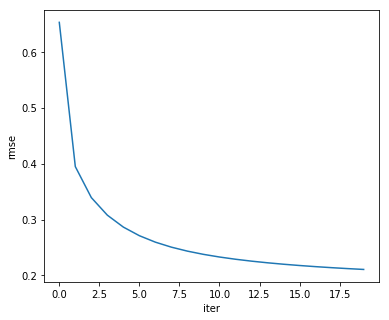

In [35]:
# 画出随着迭代次数的变化，误差平方和的变化

plt.figure(figsize=(6,5))
plt.plot(range(20),rmse_iter)
plt.xlabel('iter')
plt.ylabel('rmse')
plt.show()

In [10]:
# 在不同的正则参数下训练模型 

# 初始化模型参数
np.random.seed(1)
k = 20 
bu = np.zeros(n_users)                            
bi = np.zeros(n_items)                          
puk = random((n_users,k))/10*(np.sqrt(k))       
qki = random((k,n_items))/10*(np.sqrt(k))      
ave = np.mean(data[:,2])                     

# 定义一个模型训练函数 
def train_SVD(Lambda,bu,bi,puk,qki,ave):
    gamma = 0.1   
    maxIter = 20
    for it in range(maxIter):  
        rmse_sum = 0.0                                                   
        for i in range(n):
            u_id = userIndex[str(data[i,0])]                         
            e_id = eventIndex[str(data[i,1])]                           
            rat = int(data[i,2])                                       
            eui = rat - pred_SVD(u_id,e_id,bu,bi,puk,qki,ave)          
            rmse_sum += eui**2                                       
            bu[u_id] += gamma*(eui-Lambda*bu[u_id])                 
            bi[e_id] += gamma*(eui-Lambda*bi[e_id]) 
            temp = puk[u_id,:]
            puk[u_id,:] += gamma*(eui*qki[:,e_id]-Lambda*puk[u_id,:])
            qki[:,e_id] += gamma*(eui*temp-Lambda*qki[:,e_id])
    print('Lambda = ',Lambda, 'rmse of train data is: ',np.sqrt(rmse_sum/n)) 
    return np.sqrt(rmse_sum/n)
    
Lam = [0.00001,0.0001,0.001,0.01,0.1,1,10]
rmse = []
for Lambda in Lam:
    rmse_sum = train_SVD(Lambda,bu,bi,puk,qki,ave)
    rmse.append(rmse_sum)

Lambda =  1e-05  rmse of train data is:  0.006836769276528758
Lambda =  0.0001  rmse of train data is:  0.00027284848003831293
Lambda =  0.001  rmse of train data is:  0.0026544641135271547
Lambda =  0.01  rmse of train data is:  0.020302653627157788
Lambda =  0.1  rmse of train data is:  0.13759993707892676
Lambda =  1  rmse of train data is:  0.3204613291775001
Lambda =  10  rmse of train data is:  0.4213292605704985


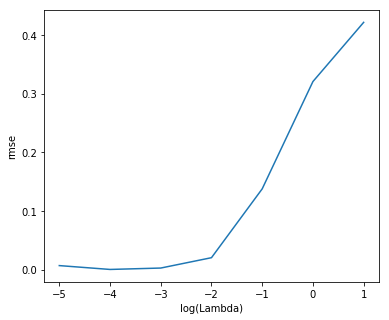

In [32]:
# 画正则参数和误差平方和的关系

plt.figure(figsize=(6,5))
plt.plot(np.log10(Lam),rmse) 
plt.xlabel('log(Lambda)')
plt.ylabel('rmse')
plt.show()

In [6]:
# 由上面结果得到，当Lambda = 0.0001时，误差平方和最小。因此预测Lambda = 0.0001时，用户对活动的打分,保存至文件svdCFReco.mtx

svdCFReco = ss.dok_matrix((n_users,n_items))    # svd 用户-活动分值矩阵

np.random.seed(1)
k = 20 
bu = np.zeros(n_users)                          
bi = np.zeros(n_items)                           
puk = random((n_users,k))/10*(np.sqrt(k))       
qki = random((k,n_items))/10*(np.sqrt(k))    
ave = np.mean(data[:,2])                      
maxIter = 20        
gamma = 0.1        
Lambda = 0.0001       

for it in range(maxIter):                                                   
    for i in range(n):
        u_id = userIndex[str(data[i,0])]                            
        e_id = eventIndex[str(data[i,1])]    
        rat = int(data[i,2])     
        svdCFReco[u_id,e_id] = pred_SVD(u_id,e_id,bu,bi,puk,qki,ave)                                    
        eui = rat - pred_SVD(u_id,e_id,bu,bi,puk,qki,ave) 
        bu[u_id] += gamma*(eui-Lambda*bu[u_id])                
        bi[e_id] += gamma*(eui-Lambda*bi[e_id]) 
        temp = puk[u_id,:]
        puk[u_id,:] += gamma*(eui*qki[:,e_id]-Lambda*puk[u_id,:])
        qki[:,e_id] += gamma*(eui*temp-Lambda*qki[:,e_id])

sio.mmwrite('svdCFReco',svdCFReco)


小结5：    
基于模型的协同过滤，通过对评分矩阵进行降维(puk * qki)和梯度下降法，在不同参数下(主要是改变正则参数Lambda)，预测用户对活动的评分，采用RMSE(总的误差平方和)作为评测标准，比较了训练集的预测分值与实际分值的误差平方和：    
1) 随着迭代次数增大，误差平方和下降，并趋于稳定。对于Lambda = 0.015，当迭代次数为20次时，误差平方和下降为：0.2106。     
2) 改变正则参数Lambda,在Lambda比较小的时候，误差平方和也比较小；随着Lambda增大，误差平方和迅速增大。当Lambda = 0.0001时，误差平方和最小，为：0.00027。    
基于模型的协同过滤比基于用户和活动的协同过滤能更好的预测用户对活动的评分，并且正则参数Lambda对预测分值的影响非常大，在Lambda<1时，预测效果比较好。    

--------------------------------------------------------
# 6.  组合各种前面生成的特征，生成新的训练数据，并对数据进行保存 

In [11]:
# 读取文件 

userCFReco = sio.mmread('userCFReco')
eventCFReco = sio.mmread('eventCFReco')
svdCFReco = sio.mmread('svdCFReco').todense() 

userReco = sio.mmread('userReco')      
eventProp_Reco = sio.mmread('eventPropReco')
eventCont_Reco = sio.mmread('eventContReco')

userPop = sio.mmread('numFriends')
friendInfluence = sio.mmread('userFriends').todense() 
eventPop = sio.mmread('eventPopularity').todense()
 

In [4]:
# 定义一个类，读取文件

class RecommonderSystem:
  
    def __init__(self):

        self.userCFReco = sio.mmread('userCFReco')
        self.eventCFReco = sio.mmread('eventCFReco')
        self.svdCFReco = sio.mmread('svdCFReco').todense() 

        self.userReco = sio.mmread('userReco')      
        self.eventProp_Reco = sio.mmread('eventPropReco')
        self.eventCont_Reco = sio.mmread('eventContReco')

        self.userPop = sio.mmread('numFriends')
        self.friendInfluence = sio.mmread('userFriends').todense() 
        self.eventPop = sio.mmread('eventPopularity').todense() 

        self.userIndex = pickle.load(open("userIndex.pkl", 'rb'))
        self.eventIndex = pickle.load(open("eventIndex.pkl", 'rb'))
        self.n_users = len(self.userIndex)
        self.n_items = len(self.eventIndex)
                      

In [9]:
# 定义一个函数，把前面基于用户、活动、模型的协同过滤，以及生成的各种特征组合在一起，生成新的训练数据，并对数据进行保存

def generateRSData(RS,train=True, header=True):
    
    fn = "train.csv" if train else "test.csv"
    fin = open(fn)
    fout = open("RS_" + fn,'w')

    fin.readline() 
    if header:
        ocolnames = ["invited", "userCF_reco", "evtCF_reco","svdCF_reco","user_reco", "evt_p_reco",\
                     "evt_c_reco", "user_pop", "frnd_infl", "evt_pop"]
        if train:
            ocolnames.append("interested")
            ocolnames.append("not_interested")
        fout.write(",".join(ocolnames) + "\n")
                
    ln = 0
    for line in fin:
        ln += 1 
        if ln%500 == 0:
            print('%s:%d (userId,eventId)=(%s,%s)' % (fn,ln,userId,eventId))
            
        cols = line.strip().split(',')
        userId = userIndex[cols[0]]
        eventId = eventIndex[cols[1]]
        invited = cols[2]

        userCF_reco = userCFReco[userId,eventId]
        itemCF_reco = eventCFReco[userId,eventId]
        svdCF_reco = svdCFReco[userId,eventId]

        user_reco = userReco[userId,eventId]
        evt_p_reco = eventProp_Reco[userId,eventId]
        evt_c_reco = eventCont_Reco[userId,eventId]
      
        user_pop = userPop[0,userId]
        frnd_infl = friendInfluence[userId].sum()
        evt_pop = eventPop[eventId,0]
        
        ocols = [invited, userCF_reco, itemCF_reco, svdCF_reco,user_reco, evt_p_reco,evt_c_reco, user_pop, frnd_infl, evt_pop]
        if train: 
            ocols.append(cols[4]) # interested
            ocols.append(cols[5]) # not_interested 
        fout.write(",".join(map(lambda x: str(x), ocols)) + "\n")
    
    fin.close()
    fout.close()    

In [5]:
RS = RecommonderSystem()

In [12]:
print("生成训练数据...")
generateRSData(RS,train=True,  header=True)

print("\n生成预测数据...")
generateRSData(RS, train=False, header=True)

生成训练数据...
train.csv:500 (userId,eventId)=(1211,8008)
train.csv:1000 (userId,eventId)=(2460,5930)
train.csv:1500 (userId,eventId)=(2257,3388)
train.csv:2000 (userId,eventId)=(436,12870)
train.csv:2500 (userId,eventId)=(1552,8147)
train.csv:3000 (userId,eventId)=(179,12719)
train.csv:3500 (userId,eventId)=(2290,13234)
train.csv:4000 (userId,eventId)=(863,12923)
train.csv:4500 (userId,eventId)=(3099,11919)
train.csv:5000 (userId,eventId)=(1180,6926)
train.csv:5500 (userId,eventId)=(404,9535)
train.csv:6000 (userId,eventId)=(2260,2364)
train.csv:6500 (userId,eventId)=(1960,9535)
train.csv:7000 (userId,eventId)=(2900,10889)
train.csv:7500 (userId,eventId)=(2021,3444)
train.csv:8000 (userId,eventId)=(2545,4270)
train.csv:8500 (userId,eventId)=(632,535)
train.csv:9000 (userId,eventId)=(294,4698)
train.csv:9500 (userId,eventId)=(1742,12762)
train.csv:10000 (userId,eventId)=(47,88)
train.csv:10500 (userId,eventId)=(461,7481)
train.csv:11000 (userId,eventId)=(1762,1882)
train.csv:11500 (userId,e

小结6：     
把前面基于用户、活动、模型的协同过滤，以及生成的各种特征组合在一起，生成新的训练数据，并保存新数据到文件RS_train.csv和RS_test.csv。

----------------------------------------------------
# 总结：  
1) 分析数据集中的用户('user')和活动('event')属性，主要分析结果保存为文件，包括：userIndex和eventIndex，eventsForUser和usersForEvent，uniqueUserPairs和uniuqeEventPairs，userMatrix，eventPropMatrix，eventContMatrix，eventPropSim，eventContSim，numFriends，userFriendseventPopularity。 

2) 基于用户的协同过滤，用两种方法计算两个用户user_1和user_2之间的相似度，再预测用户对活动的评分，采用RMSE(总的误差平方和)作为评测标准，比较了训练集的预测分值与实际分值的误差平方和。     
2.1) 根据两个用户对所有活动的打分，用Pearson相关系数(公式的第三种形式)计算两个用户的相似度，再由用户相似度计算用户对活动的推荐评分(userCFReco.mtx文件)，得到在训练集上预测分值与实际分值的误差平方和为：0.51797。      
2.2) 根据用户本身的特征属性，用Pearson相关系数(公式的第一种形式)计算两个用户的相似度，得到在训练集上预测分值与实际分值的误差平方和为：0.51794。      
由两种方法计算相似度得到的预测分值与实际分值的误差平方和相同。

3) 基于活动的协同过滤，用两种方法计算两个活动event_1和event_2之间的相似度，再预测用户对活动的评分，比较了训练集的预测分值与实际分值的误差平方和。     
3.1) 根据所有用户对两个不同活动的打分，用Pearson相关系数计算两个活动的相似度，得到在训练集上预测分值与实际分值的误差平方和为：0.5181。   
3.2) 根据活动本身的特征属性，分别对非词频特征和词频特征用Pearson相关系数计算两个活动的相似度，得到非词频特征和词频特征在训练集上预测分值与实际分值的误差平方和都是0.5180。       
由两种方法计算相似度得到的预测分值与实际分值的误差平方和相同，并且根据不同的特征属性，非词频特征和词频特征得到的误差平方和也是相同的。   

4) 基于模型的协同过滤，通过对评分矩阵进行降维(puk * qki)和梯度下降法，在不同参数下(主要是改变正则参数Lambda)，预测用户对活动的评分，比较了训练集的预测分值与实际分值的误差平方和。     
4.1) 随着迭代次数增大，误差平方和下降，并趋于稳定。对于Lambda = 0.015，当迭代次数为20次时，误差平方和下降为：0.2106。     
4.2) 改变正则参数Lambda,在Lambda比较小的时候，误差平方和也比较小；随着Lambda增大，误差平方和迅速增大。当Lambda = 0.0001时，误差平方和最小，为：0.00027。     

5) 把前面基于用户、活动、模型的协同过滤，以及生成的各种特征组合在一起，生成新的训练数据，并保存新数据到文件RS_train.csv和RS_test.csv。 

结论：       
1)  基于用户和基于活动的协同过滤得到的误差平方和相同(相近)。     
2) 基于模型的协同过滤比基于用户和活动的协同过滤能更好的预测用户对活动的评分，并且正则参数Lambda对预测分值的影响非常大，在Lambda<1时，预测效果比较好。    
